In [4]:
# unzip dataset_letras.zip
!unzip dataset_letras.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset_letras/Q/Q_106.png  
 extracting: dataset_letras/Q/Q_107.png  
 extracting: dataset_letras/Q/Q_108.png  
 extracting: dataset_letras/Q/Q_109.png  
 extracting: dataset_letras/Q/Q_11.png  
 extracting: dataset_letras/Q/Q_110.png  
 extracting: dataset_letras/Q/Q_111.png  
 extracting: dataset_letras/Q/Q_112.png  
 extracting: dataset_letras/Q/Q_113.png  
 extracting: dataset_letras/Q/Q_114.png  
 extracting: dataset_letras/Q/Q_115.png  
 extracting: dataset_letras/Q/Q_116.png  
 extracting: dataset_letras/Q/Q_117.png  
 extracting: dataset_letras/Q/Q_118.png  
 extracting: dataset_letras/Q/Q_119.png  
 extracting: dataset_letras/Q/Q_12.png  
 extracting: dataset_letras/Q/Q_120.png  
 extracting: dataset_letras/Q/Q_121.png  
 extracting: dataset_letras/Q/Q_122.png  
 extracting: dataset_letras/Q/Q_123.png  
 extracting: dataset_letras/Q/Q_124.png  
 extracting: dataset_letras/Q/Q_125.png  
 extracting: dataset_letras

In [5]:
!pip install wandb

In [6]:
import wandb

## Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

## Inicializa WandB
wandb.init(project="repte1_psiv", entity="andreu-mir")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andreu-mir. Use `wandb login --relogin` to force relogin


# 1. Arquitectura model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCNModel(nn.Module):
    def __init__(self):
        super(FCNModel, self).__init__()

        # Aplanar imágenes 1x64x40 a un vector de 2560 elementos (64*40)
        self.fc1 = nn.Linear(1 * 64 * 40, 512)  # Primera capa totalmente conectada
        self.fc2 = nn.Linear(512, 128)          # Segunda capa
        self.fc3 = nn.Linear(128, 26)           # Capa de salida para 26 clases
        self.dropout = nn.Dropout(0.5)          # Dropout para regularización

    def forward(self, x):
        x = x.view(-1, 1 * 64 * 40)             # Aplanar las imágenes (batch_size, 1*64*40)
        x = F.relu(self.fc1(x))                 # Capa oculta 1 con ReLU
        x = self.dropout(x)                     # Aplicar dropout
        x = F.relu(self.fc2(x))                 # Capa oculta 2 con ReLU
        x = self.fc3(x)                         # Capa de salida
        return x

# Crear una instancia del modelo
model = FCNModel()


# 2. Dataset

In [8]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar WandB
wandb.init(project="letra_recognition_FCN")

# Definición de parámetros
batch_size = 32
img_height, img_width = 64, 40  # Tamaño de las imágenes

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Redimensionar las imágenes
    transforms.Grayscale(num_output_channels=1),  # Asegurarse de que la imagen sea en escala de grises
    transforms.ToTensor(),  # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,)),  # Normalizar las imágenes (grayscale)
])

# Cargar el dataset
base_dir = 'dataset_letras'
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Número de pliegues para la validación cruzada
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Verificación
print(f"Total dataset size: {len(dataset)}")

Total dataset size: 13000


# 3. Train Model

In [9]:
import torch.nn as nn
import torch.optim as optim

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# see shape of dataset_letras\0\0_0.png

print(dataset[0][0].shape)

torch.Size([1, 64, 40])


Fold 1/5
Epoch [1/20], Loss: 1.0466, Accuracy: 0.6924
Epoch [2/20], Loss: 0.2767, Accuracy: 0.9100
Epoch [3/20], Loss: 0.1820, Accuracy: 0.9373
Epoch [4/20], Loss: 0.1317, Accuracy: 0.9545
Epoch [5/20], Loss: 0.1012, Accuracy: 0.9636
Epoch [6/20], Loss: 0.0987, Accuracy: 0.9641
Epoch [7/20], Loss: 0.0727, Accuracy: 0.9743
Epoch [8/20], Loss: 0.0636, Accuracy: 0.9767
Epoch [9/20], Loss: 0.0554, Accuracy: 0.9807
Epoch [10/20], Loss: 0.0643, Accuracy: 0.9765
Epoch [11/20], Loss: 0.0548, Accuracy: 0.9784
Epoch [12/20], Loss: 0.0480, Accuracy: 0.9824
Epoch [13/20], Loss: 0.0384, Accuracy: 0.9866
Epoch [14/20], Loss: 0.0342, Accuracy: 0.9869
Epoch [15/20], Loss: 0.0398, Accuracy: 0.9856
Epoch [16/20], Loss: 0.0408, Accuracy: 0.9858
Epoch [17/20], Loss: 0.0330, Accuracy: 0.9883
Epoch [18/20], Loss: 0.0329, Accuracy: 0.9877
Epoch [19/20], Loss: 0.0292, Accuracy: 0.9899
Epoch [20/20], Loss: 0.0297, Accuracy: 0.9894
Validation Loss: 0.0505, Validation Accuracy: 0.9885
Validation Precision: 0.988

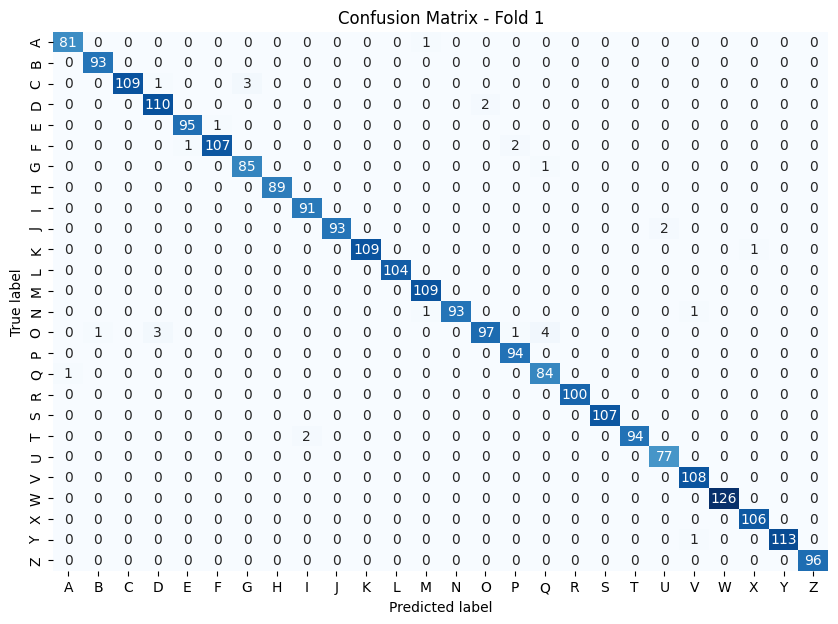

Fold 2/5
Epoch [1/20], Loss: 0.0526, Accuracy: 0.9839
Epoch [2/20], Loss: 0.0309, Accuracy: 0.9896
Epoch [3/20], Loss: 0.0290, Accuracy: 0.9896
Epoch [4/20], Loss: 0.0263, Accuracy: 0.9913
Epoch [5/20], Loss: 0.0283, Accuracy: 0.9899
Epoch [6/20], Loss: 0.0259, Accuracy: 0.9909
Epoch [7/20], Loss: 0.0229, Accuracy: 0.9911
Epoch [8/20], Loss: 0.0211, Accuracy: 0.9931
Epoch [9/20], Loss: 0.0210, Accuracy: 0.9934
Epoch [10/20], Loss: 0.0212, Accuracy: 0.9920
Epoch [11/20], Loss: 0.0213, Accuracy: 0.9933
Epoch [12/20], Loss: 0.0188, Accuracy: 0.9933
Epoch [13/20], Loss: 0.0215, Accuracy: 0.9927
Epoch [14/20], Loss: 0.0260, Accuracy: 0.9911
Epoch [15/20], Loss: 0.0161, Accuracy: 0.9945
Epoch [16/20], Loss: 0.0170, Accuracy: 0.9938
Epoch [17/20], Loss: 0.0111, Accuracy: 0.9966
Epoch [18/20], Loss: 0.0197, Accuracy: 0.9927
Epoch [19/20], Loss: 0.0141, Accuracy: 0.9956
Epoch [20/20], Loss: 0.0169, Accuracy: 0.9935
Validation Loss: 0.0086, Validation Accuracy: 0.9962
Validation Precision: 0.996

<Figure size 640x480 with 0 Axes>

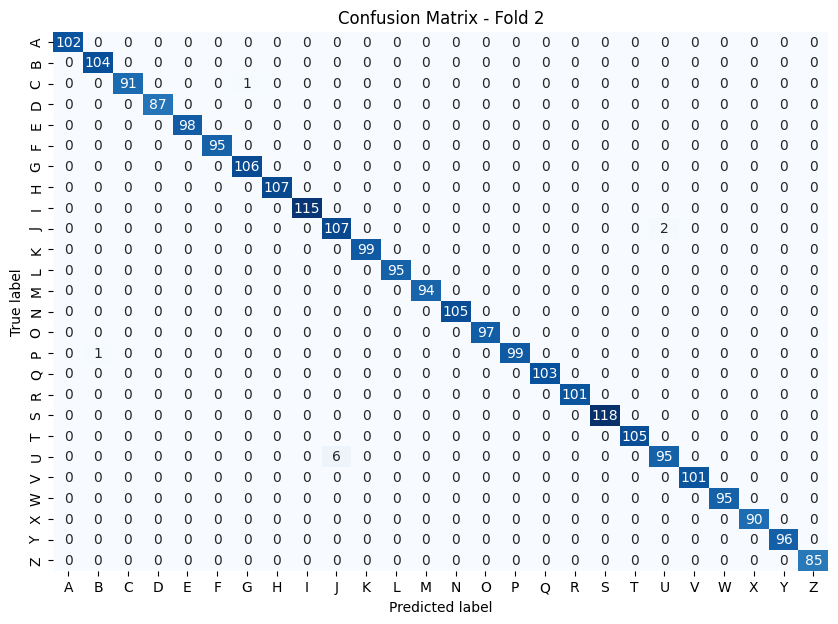

Fold 3/5
Epoch [1/20], Loss: 0.0271, Accuracy: 0.9912
Epoch [2/20], Loss: 0.0175, Accuracy: 0.9936
Epoch [3/20], Loss: 0.0147, Accuracy: 0.9953
Epoch [4/20], Loss: 0.0122, Accuracy: 0.9955
Epoch [5/20], Loss: 0.0160, Accuracy: 0.9946
Epoch [6/20], Loss: 0.0123, Accuracy: 0.9953
Epoch [7/20], Loss: 0.0113, Accuracy: 0.9962
Epoch [8/20], Loss: 0.0118, Accuracy: 0.9955
Epoch [9/20], Loss: 0.0155, Accuracy: 0.9952
Epoch [10/20], Loss: 0.0155, Accuracy: 0.9948
Epoch [11/20], Loss: 0.0104, Accuracy: 0.9960
Epoch [12/20], Loss: 0.0153, Accuracy: 0.9946
Epoch [13/20], Loss: 0.0127, Accuracy: 0.9957
Epoch [14/20], Loss: 0.0100, Accuracy: 0.9963
Epoch [15/20], Loss: 0.0146, Accuracy: 0.9948
Epoch [16/20], Loss: 0.0150, Accuracy: 0.9954
Epoch [17/20], Loss: 0.0099, Accuracy: 0.9970
Epoch [18/20], Loss: 0.0069, Accuracy: 0.9973
Epoch [19/20], Loss: 0.0115, Accuracy: 0.9962
Epoch [20/20], Loss: 0.0094, Accuracy: 0.9972
Validation Loss: 0.0050, Validation Accuracy: 0.9981
Validation Precision: 0.998

<Figure size 640x480 with 0 Axes>

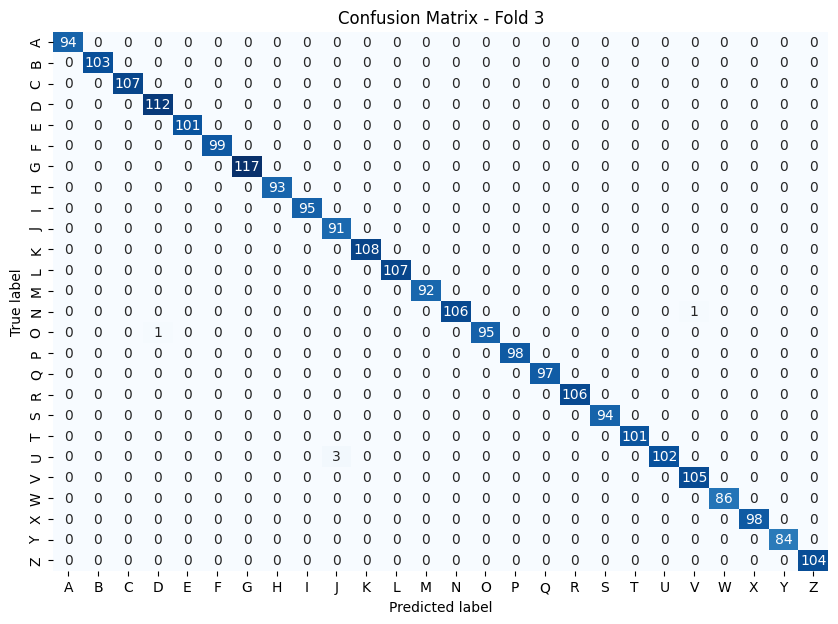

Fold 4/5
Epoch [1/20], Loss: 0.0167, Accuracy: 0.9951
Epoch [2/20], Loss: 0.0154, Accuracy: 0.9957
Epoch [3/20], Loss: 0.0128, Accuracy: 0.9965
Epoch [4/20], Loss: 0.0071, Accuracy: 0.9979
Epoch [5/20], Loss: 0.0117, Accuracy: 0.9962
Epoch [6/20], Loss: 0.0090, Accuracy: 0.9971
Epoch [7/20], Loss: 0.0075, Accuracy: 0.9975
Epoch [8/20], Loss: 0.0093, Accuracy: 0.9968
Epoch [9/20], Loss: 0.0049, Accuracy: 0.9983
Epoch [10/20], Loss: 0.0073, Accuracy: 0.9979
Epoch [11/20], Loss: 0.0093, Accuracy: 0.9970
Epoch [12/20], Loss: 0.0122, Accuracy: 0.9965
Epoch [13/20], Loss: 0.0139, Accuracy: 0.9955
Epoch [14/20], Loss: 0.0062, Accuracy: 0.9972
Epoch [15/20], Loss: 0.0036, Accuracy: 0.9986
Epoch [16/20], Loss: 0.0051, Accuracy: 0.9980
Epoch [17/20], Loss: 0.0083, Accuracy: 0.9980
Epoch [18/20], Loss: 0.0137, Accuracy: 0.9959
Epoch [19/20], Loss: 0.0116, Accuracy: 0.9958
Epoch [20/20], Loss: 0.0053, Accuracy: 0.9982
Validation Loss: 0.0011, Validation Accuracy: 0.9992
Validation Precision: 0.999

<Figure size 640x480 with 0 Axes>

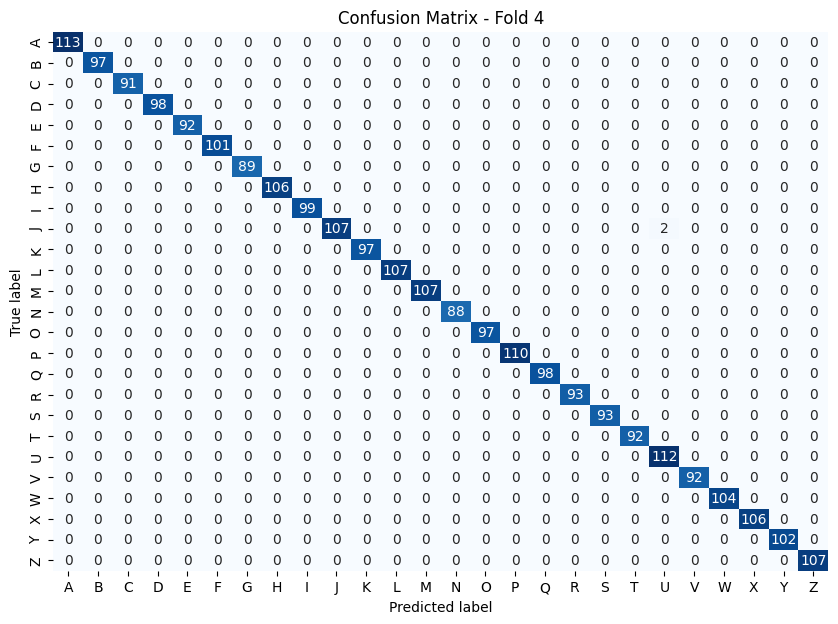

Fold 5/5
Epoch [1/20], Loss: 0.0071, Accuracy: 0.9976
Epoch [2/20], Loss: 0.0119, Accuracy: 0.9966
Epoch [3/20], Loss: 0.0077, Accuracy: 0.9970
Epoch [4/20], Loss: 0.0083, Accuracy: 0.9969
Epoch [5/20], Loss: 0.0112, Accuracy: 0.9965
Epoch [6/20], Loss: 0.0073, Accuracy: 0.9974
Epoch [7/20], Loss: 0.0077, Accuracy: 0.9974
Epoch [8/20], Loss: 0.0084, Accuracy: 0.9967
Epoch [9/20], Loss: 0.0056, Accuracy: 0.9985
Epoch [10/20], Loss: 0.0079, Accuracy: 0.9977
Epoch [11/20], Loss: 0.0112, Accuracy: 0.9968
Epoch [12/20], Loss: 0.0075, Accuracy: 0.9977
Epoch [13/20], Loss: 0.0042, Accuracy: 0.9986
Epoch [14/20], Loss: 0.0103, Accuracy: 0.9976
Epoch [15/20], Loss: 0.0062, Accuracy: 0.9981
Epoch [16/20], Loss: 0.0077, Accuracy: 0.9979
Epoch [17/20], Loss: 0.0049, Accuracy: 0.9984
Epoch [18/20], Loss: 0.0078, Accuracy: 0.9971
Epoch [19/20], Loss: 0.0078, Accuracy: 0.9974
Epoch [20/20], Loss: 0.0092, Accuracy: 0.9969
Validation Loss: 0.0011, Validation Accuracy: 0.9996
Validation Precision: 0.999

<Figure size 640x480 with 0 Axes>

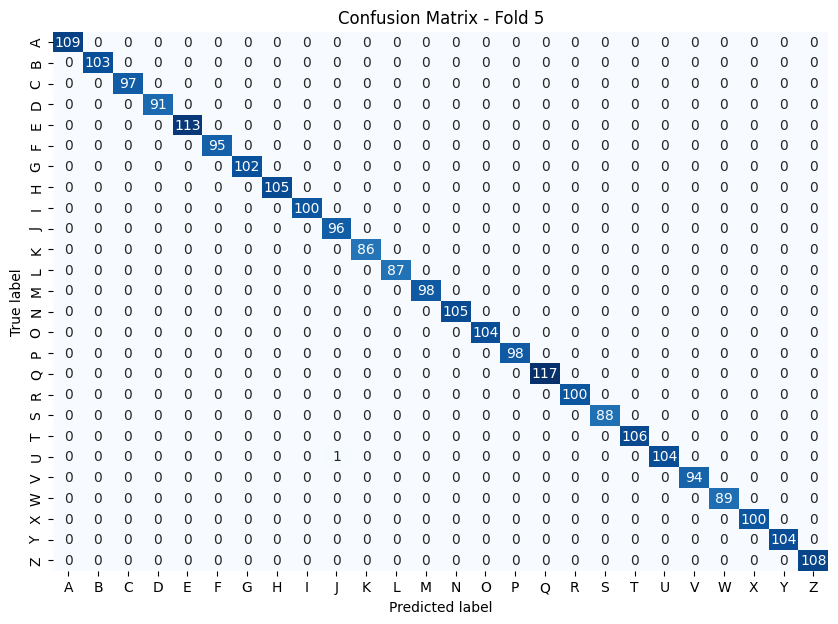

<Figure size 640x480 with 0 Axes>

In [11]:
# # Entrenamiento del modelo

# # Move the model to the GPU before training
# model.to('cuda') # This line is added to move the model's weights to the GPU

# train_losses = []
# train_accuracies = []

# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for images, labels in train_loader:
#         images = images.to('cuda')  # Usa 'cuda' si tienes GPU
#         labels = labels.to('cuda')  # Usa 'cuda' si tienes GPU

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Calcular precisión
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     # Calcula y registra la pérdida y la precisión
#     epoch_loss = running_loss / len(train_loader)
#     epoch_accuracy = correct / total

#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_accuracy)

#     # Log metrics to WandB
#     wandb.log({
#         "epoch": epoch + 1,
#         "loss": epoch_loss,
#         "accuracy": epoch_accuracy,
#     })

#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')



# Loop a través de los pliegues
for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
    print(f'Fold {fold + 1}/{num_folds}')

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    # Crear DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Mover el modelo a la GPU
    model.to('cuda')

    train_losses = []
    train_accuracies = []

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to('cuda')  # Usa 'cuda' si tienes GPU
            labels = labels.to('cuda')  # Usa 'cuda' si tienes GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcula y registra la pérdida y la precisión
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_accuracy,
        })

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    # Calcula y muestra la pérdida y precisión de validación
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct / val_total

    # Calcular métricas adicionales
    precision = precision_score(val_labels, val_predictions, average='weighted')
    recall = recall_score(val_labels, val_predictions, average='weighted')
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    cm = confusion_matrix(val_labels, val_predictions)

    # Log métricas de validación a WandB
    wandb.log({
        "fold": fold + 1,
        "val_loss": val_epoch_loss,
        "val_accuracy": val_epoch_accuracy,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
    })

    # Imprimir métricas
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Guardar la figura
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.show()
    plt.clf()  # Limpiar la figura para la próxima iteración




In [12]:
# Finaliza la sesión de WandB
wandb.finish()

accuracy,▁▂▃▄▅▅▆▇▇▇▇▇▇▇█▇██▇▇████████████████████
epoch,▂▃▄▅▅▇▇█▃▃▄▄▅▆▆▇█▁▃▅▅▆▇▇▇▁▂▂▂▄▅▅▁▁▂▃▄▄▅▇
fold,▁▃▅▆█
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇██
val_f1,▁▆▇██
val_loss,█▂▂▁▁
val_precision,▁▆▇██
val_recall,▁▆▇██
accuracy,0.99692
epoch,20


In [14]:
model_save_path = f'model_letter_classifier_FCN.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to model_letter_classifier_cnn.pth
